In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
batch_size = 64
learning_rate = 0.001

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.CenterCrop((224, 224)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/train',
                                 transform=train_trans,
                                 )

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/val',
                                 transform=val_trans,
                                 )

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/test',
                                 transform=val_trans,
                                 )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
class depthwise_block(nn.Module):
    def __init__(self, in_channels, out_channels, stride, groups=1):
        super(depthwise_block, self).__init__()

        # dw

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=in_channels,
                               kernel_size=(3, 3),
                               stride=stride,
                               padding=(1, 1),
                               groups=groups
                               )

        self.bn1 = nn.BatchNorm2d(num_features=in_channels)
        self.relu = nn.ReLU()  # should have used ReLU6!

        # pw

        self.conv2 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=(1, 1),
                               stride=(1, 1),
                               padding=(0, 0),
                               )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, X):
        out = self.relu(self.bn1(self.conv1(X)))
        out = self.relu(self.bn2(self.conv2(out)))

        return out

class MobilenetV1(nn.Module):
    def __init__(self, in_channels, num_classes, width_multiplier=1.0):
        super(MobilenetV1, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=int(32 * width_multiplier),
                              kernel_size=(3, 3),
                              stride=(2, 2),
                              padding=(1, 1),
                              )
        self.bn = nn.BatchNorm2d(num_features=int(32 * width_multiplier))
        self.relu = nn.ReLU()

        self.dconv1 = depthwise_block(in_channels=int(32 * width_multiplier),
                                      out_channels=int(64 * width_multiplier),
                                      stride=(1, 1),
                                      groups=int(32 * width_multiplier))

        self.dconv2 = depthwise_block(in_channels=int(64 * width_multiplier),
                                      out_channels=int(128 * width_multiplier),
                                      stride=(2, 2),
                                      groups=int(64 * width_multiplier))

        self.dconv3 = depthwise_block(in_channels=int(128 * width_multiplier),
                                      out_channels=int(128 * width_multiplier),
                                      stride=(1, 1),
                                      groups=int(128 * width_multiplier))

        self.dconv4 = depthwise_block(in_channels=int(128 * width_multiplier),
                                      out_channels=int(256 * width_multiplier),
                                      stride=(2, 2),
                                      groups=int(128 * width_multiplier))

        self.dconv5 = depthwise_block(in_channels=int(256 * width_multiplier),
                                      out_channels=int(256 * width_multiplier),
                                      stride=(1, 1),
                                      groups=int(256 * width_multiplier))

        self.dconv6 = depthwise_block(in_channels=int(256 * width_multiplier),
                                      out_channels=int(512 * width_multiplier),
                                      stride=(2, 2),
                                      groups=int(256 * width_multiplier))

        self.dconv7 = depthwise_block(in_channels=int(512 * width_multiplier),  # 5 times
                                      out_channels=int(512 * width_multiplier),
                                      stride=(1, 1),
                                      groups=int(512 * width_multiplier))

        self.dconv8 = depthwise_block(in_channels=int(512 * width_multiplier),
                                      out_channels=int(1024 * width_multiplier),
                                      stride=(2, 2),
                                      groups=int(512 * width_multiplier))

        self.dconv9 = depthwise_block(in_channels=int(1024 * width_multiplier),
                                      out_channels=int(1024 * width_multiplier),
                                      stride=(1, 1),
                                      groups=int(1024 * width_multiplier))

        self.avgpool = nn.AvgPool2d(kernel_size=(7, 7),
                                    stride=(1, 1),
                                    padding=(0, 0))

        self.fc = nn.Linear(in_features=int(1024 * width_multiplier),
                            out_features=num_classes)

    def forward(self, X):
        # shape of X is torch.Size([1, 3, 224, 224])
        out = self.relu(self.bn(self.conv(X)))
        # torch.Size([1, 32, 112, 112]), stride=2
        out = self.dconv1(out)
        # torch.Size([1, 32, 112, 112]), stride=1
        # torch.Size([1, 64, 112, 112]), stride=1
        out = self.dconv2(out)
        # torch.Size([1, 64, 56, 56])
        # torch.Size([1, 128, 56, 56]) 1st
        out = self.dconv3(out)
        # torch.Size([1, 128, 56, 56]) 2nd
        # torch.Size([1, 128, 56, 56]) 3rd
        out = self.dconv4(out)
        # torch.Size([1, 128, 28, 28])
        # torch.Size([1, 256, 28, 28])
        out = self.dconv5(out)
        out = self.dconv6(out)

        out = self.dconv7(out)
        out = self.dconv7(out)
        out = self.dconv7(out)
        out = self.dconv7(out)
        out = self.dconv7(out)

        out = self.dconv8(out)
        out = self.dconv9(out)

        out = self.avgpool(out)
        # out = out.view(out.size(0), 1024 * 1 * 1)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out

In [ ]:
model = MobilenetV1(in_channels=3,
                 num_classes=2, width_multiplier=0.5).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# checkpoint = torch.load('/content/drive/MyDrive/mobilenetv1_on_hymeno.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['model_optimizer'])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_loop (model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc):

  best_acc=0.0

  for epoch in range(num_epochs):

      model.train()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          z_scores = model(images)
          loss = criterion(z_scores, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          _, predictions = torch.max(z_scores, 1)
          running_corrects += torch.sum(predictions == labels)

      epoch_loss = running_loss / len(train_dataset)
      epoch_acc = running_corrects / len(train_dataset)
      print(f'Epoch {epoch+1} / {num_epochs}, '
            f'Train Loss {epoch_loss:.4f}, '
            f'Train Acc {epoch_acc:.4f}')

      train_acc_hist.append(epoch_acc)
      loss_train.append(epoch_loss)

      step_lr_scheduler.step()

      model.eval()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(val_loader):
          images = images.to(device)
          labels = labels.to(device)

          with torch.no_grad():
              z_scores = model(images)
              loss = criterion(z_scores, labels)

              running_loss += loss.item() * images.size(0)
              _, predictions = torch.max(z_scores, 1)
              running_corrects += torch.sum(predictions == labels)

      epoch_loss_val = running_loss / len(val_dataset)
      epoch_acc_val = running_corrects / len(val_dataset)
      print(f'Epoch {epoch + 1} / {num_epochs}, '
            f'Val Loss {epoch_loss_val:.4f}, '
            f'Val Acc {epoch_acc_val:.4f}')

      val_acc_hist.append(epoch_acc_val)
      loss_val.append(epoch_loss_val)

      if epoch_acc_val > best_acc:
          best_acc = epoch_acc_val

In [ ]:
def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
num_epochs = 30
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
start = time.time()
train_loop(model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc)
time_elapsed = time.time() - start

Epoch 1 / 30, Train Loss 0.7276, Train Acc 0.5533
Epoch 1 / 30, Val Loss 0.6940, Val Acc 0.4301
Epoch 2 / 30, Train Loss 0.6958, Train Acc 0.5000
Epoch 2 / 30, Val Loss 0.7113, Val Acc 0.4301
Epoch 3 / 30, Train Loss 0.7103, Train Acc 0.5164
Epoch 3 / 30, Val Loss 0.7361, Val Acc 0.4301
Epoch 4 / 30, Train Loss 0.6747, Train Acc 0.5697
Epoch 4 / 30, Val Loss 0.7774, Val Acc 0.4301
Epoch 5 / 30, Train Loss 0.6676, Train Acc 0.5902
Epoch 5 / 30, Val Loss 0.8924, Val Acc 0.4301
Epoch 6 / 30, Train Loss 0.6756, Train Acc 0.5656
Epoch 6 / 30, Val Loss 1.1220, Val Acc 0.4301
Epoch 7 / 30, Train Loss 0.6714, Train Acc 0.5943
Epoch 7 / 30, Val Loss 1.1771, Val Acc 0.4301
Epoch 8 / 30, Train Loss 0.6443, Train Acc 0.6516
Epoch 8 / 30, Val Loss 1.1082, Val Acc 0.4301
Epoch 9 / 30, Train Loss 0.6657, Train Acc 0.5410
Epoch 9 / 30, Val Loss 1.0744, Val Acc 0.4194
Epoch 10 / 30, Train Loss 0.6578, Train Acc 0.5984
Epoch 10 / 30, Val Loss 0.9551, Val Acc 0.4301
Epoch 11 / 30, Train Loss 0.6475, Trai

In [ ]:
calculate_time(time_elapsed)

Training complete in 4m 8s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.0000


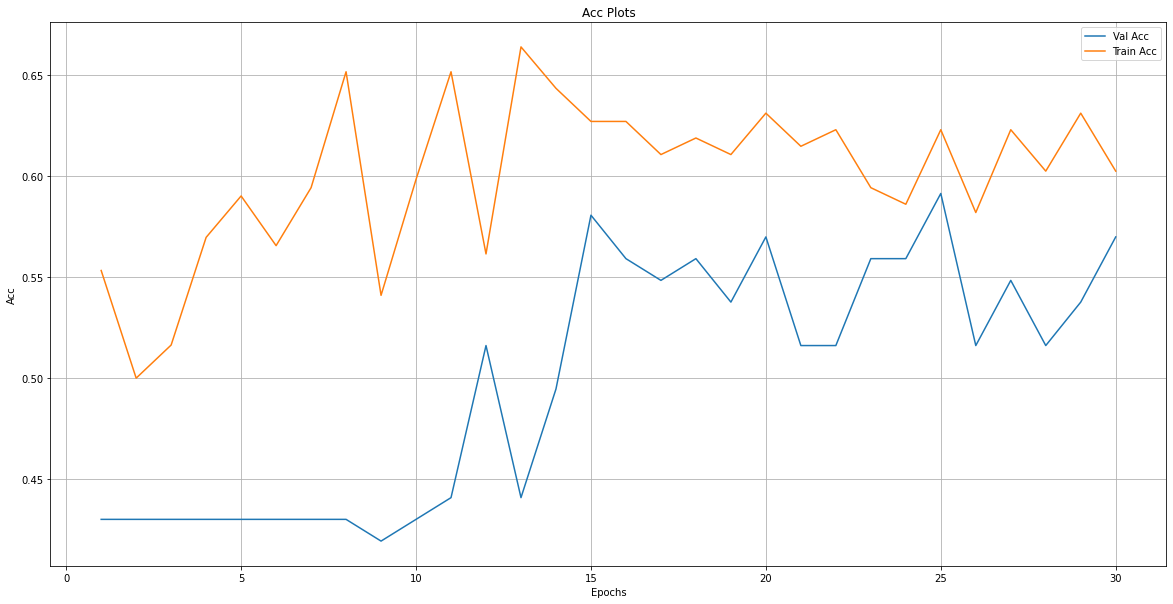

In [ ]:
val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

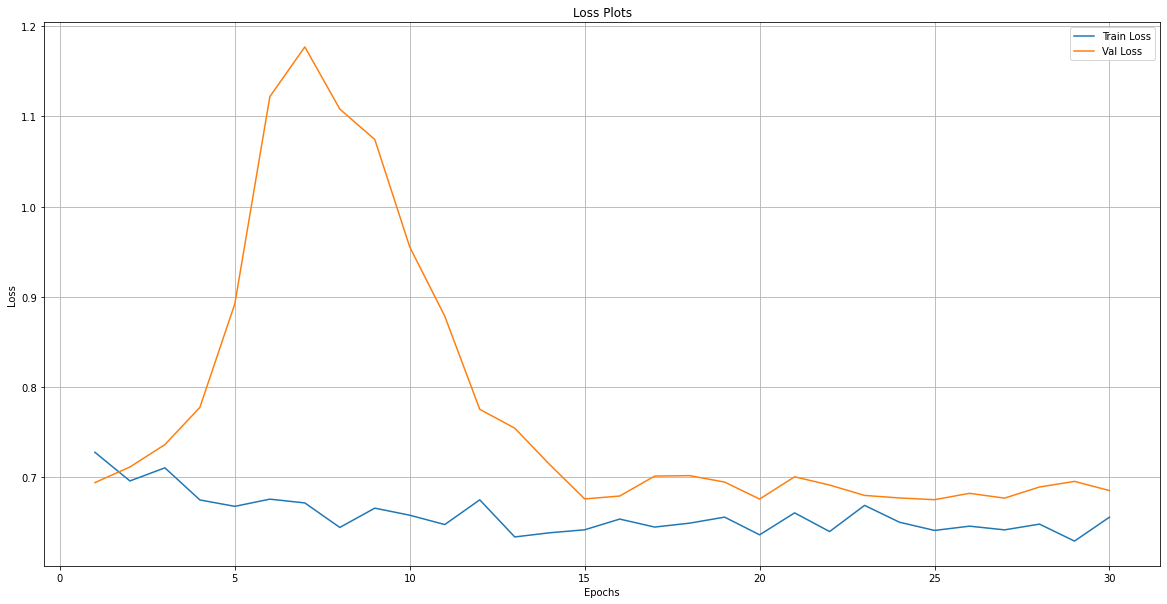

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.6500


In [ ]:
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/mobilenetv1_on_hymeno_0.5.pth')